In [67]:
# Parameters

# Mesh parameters
MESH_DENSITY = 8
INLET_VELOCITY = 1.5 # m/s

# Simulation parameters
SIMULATION_TIME = 2
TIME_STEP_LENGTH = 10**-3
N_TIME_STEPS = int(SIMULATION_TIME/TIME_STEP_LENGTH)
FILENAME = 'advanced'

# Fluid properties
DENSITY = 1 # kg/m^3
VISCOSITY = 10**-3 # Pa*s (N*s/m^2) 
THERMAL_CONDUCTIVITY = 0.598 # W/(m * K) 
SPECIFIC_HEAT_CAPACITY = 4184 # J/(kg * K) 


print('(Derived constants)')
print(f'Reybolds Number (Re): {DENSITY*INLET_VELOCITY*0.41/VISCOSITY:.5f}')
print(f'Kinematic viscosity (nu) [m^2/s]: {VISCOSITY / DENSITY}',)
print(f'Thermal diffusivity (kappa) [m^2/s]: {THERMAL_CONDUCTIVITY/(DENSITY*SPECIFIC_HEAT_CAPACITY)}',)

print('(Simulation)')
print(f'Time step [s]: {TIME_STEP_LENGTH}')
print(f'Total time [s]: {SIMULATION_TIME}')
print(f'Iterations: {N_TIME_STEPS}')
print(f'Mesh density: {MESH_DENSITY}')


(Derived constants)
Reybolds Number (Re): 615.00000
Kinematic viscosity (nu) [m^2/s]: 0.001
Thermal diffusivity (kappa) [m^2/s]: 0.00014292543021032504
(Simulation)
Time step [s]: 0.001
Total time [s]: 2
Iterations: 2000
Mesh density: 8


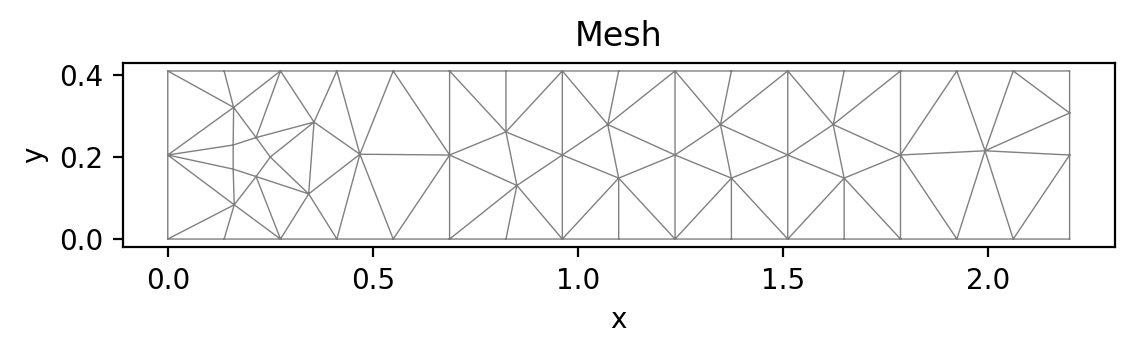

Number of cell elements: 80


In [68]:
# Define mesh
import fenics as fe
import mshr as ms
import matplotlib.pyplot as plt

# Create the mesh using Constructive solid geometry (CSG)
# box = ms.Rectangle(fe.Point(0.0, 0.0), fe.Point(1.0, 1.0))
# hole = ms.Rectangle(fe.Point(0.2,0.4),fe.Point(0.8,0.6)) # 
# domain = box 

channel = ms.Rectangle(
    fe.Point(0.0,0.0),
    fe.Point(2.2,0.41)
)
cylinder = ms.Circle(fe.Point(0.2,0.2),0.05)

domain = channel - cylinder
mesh = ms.generate_mesh(domain, MESH_DENSITY)

# If loading mesh from file
# mesh = fe.Mesh('path.xml')

fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('x')
ax.set_ylabel('y')
fe.plot(mesh, title='Mesh',linewidth=0.5)
plt.show()

print('Number of cell elements:',mesh.num_cells())
fe.set_log_active(False) # suspend FEniCS output

In [69]:
# Form compiler options
fe.parameters["form_compiler"]["optimize"]     = True
fe.parameters["form_compiler"]["cpp_optimize"] = True
#fe.parameters["form_compiler"]["representation"] = "quadrature"

In [70]:
# Define the function spaces
# Taylor-Hood Elements. The order of the function space for the pressure has
# to be one order lower than for the velocity
velocity_function_space = fe.VectorFunctionSpace(mesh, "Lagrange", 2)
pressure_function_space = fe.FunctionSpace(mesh, "Lagrange", 1)
heat_function_space = fe.FunctionSpace(mesh,'Lagrange', 1)

# Define the trial and test functions
u = fe.TrialFunction(velocity_function_space)
v = fe.TestFunction(velocity_function_space)
p = fe.TrialFunction(pressure_function_space)
q = fe.TestFunction(pressure_function_space)
t = fe.TrialFunction(heat_function_space)
w = fe.TestFunction(heat_function_space)

In [71]:
# Define the Boundary Condition
walls= 'on_boundary'
top_boundary= 'on_boundary && near(x[1], 0.41)'
bottom_boundary= 'on_boundary && near(x[1], 0.0)'
left_boundary= 'on_boundary && near(x[0], 0.0)'
right_boundary= 'on_boundary && near(x[0], 2.2)'

noslip = fe.Constant((0.0, 0.0))

inflow_profile = fe.Expression(
    ('4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)', '0'),
    degree = 2
)

velocity_boundary_conditions = [
    fe.DirichletBC(velocity_function_space, noslip, walls),
    fe.DirichletBC(velocity_function_space, inflow_profile, left_boundary)
]

pressure_boundary_conditions = [
    fe.DirichletBC(pressure_function_space, 0.0, right_boundary)
]

heat_boundary_conditions = [
    fe.DirichletBC(heat_function_space, 200, left_boundary),
    fe.DirichletBC(heat_function_space, 0, right_boundary)
]


In [72]:
# Define the solution fields involved
u_prev = fe.Function(velocity_function_space) # velocity at previous time step, used for time integration
u_next = fe.Function(velocity_function_space) # velocity before pressure correction
u_next = fe.Function(velocity_function_space,name='Velocity') # velocity after pressure correction, at current time step
p_next = fe.Function(pressure_function_space,name='Pressure') # pressure at current time step
p_prev = fe.Function(pressure_function_space)
t_prev = fe.Function(heat_function_space)
t_next = fe.Function(heat_function_space,name='Heat')


In [73]:
# Set initial conditions
pass

In [74]:
# Define weak forms
dt = fe.Constant(TIME_STEP_LENGTH)
rho = fe.Constant(DENSITY)
nu = fe.Constant(VISCOSITY / DENSITY)
mu = fe.Constant(VISCOSITY)
kappa = fe.Constant(THERMAL_CONDUCTIVITY/(DENSITY*SPECIFIC_HEAT_CAPACITY))
n = fe.FacetNormal(mesh)
U = 0.5*(u_prev + u)

# u_ = u^n+1 -> u_next
# u_n = u^n -> u_prev

# Strain-rate tensor
def epsilon(u):
    return fe.sym(fe.nabla_grad(u))

# Viscous stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*fe.Identity(len(u))

# Define variational problem for step 1
momentum_residuum = (
    rho*fe.dot((u - u_prev) / dt, v)*fe.dx  
   + rho*fe.dot(fe.dot(u_prev, fe.nabla_grad(u_prev)), v)*fe.dx  
   + fe.inner(sigma(U, p_prev), epsilon(v))*fe.dx  
   + fe.dot(p_prev*n, v)*fe.ds - fe.dot(mu*fe.nabla_grad(U)*n, v)*fe.ds)
   #- fe.dot(f, v)*fe.dx)

# Define variational problem for step 2
pressure_residuum = (
    fe.dot(fe.nabla_grad(p), fe.nabla_grad(q))*fe.dx
    - fe.dot(fe.nabla_grad(p_prev), fe.nabla_grad(q))*fe.dx
    + (1/dt)*fe.div(u_next)*q*fe.dx
)

# Define variational problem for step 3
velocity_update_residuum = (
    fe.dot(u, v)*fe.dx
    - fe.dot(u_next, v)*fe.dx
    + dt*fe.dot(fe.nabla_grad(p_next - p_prev), v)*fe.dx
)

heat_residuum = (
    (1.0 / dt) * fe.inner(t - t_prev, w) * fe.dx
    +
    fe.dot(u_next,fe.grad(t_prev)) * w *fe.dx # Advection
    +
    kappa * fe.inner(fe.grad(t_prev), fe.grad(w)) * fe.dx # Diffusion term
)



In [75]:
# Assemble system matricies
# used to solve linear (Ax=b) systems 
momentum_lhs = fe.lhs(momentum_residuum)
momentum_rhs = fe.rhs(momentum_residuum)
momentum_A = fe.assemble(momentum_lhs)

pressure_lhs = fe.lhs(pressure_residuum)
pressure_rhs = fe.rhs(pressure_residuum)
pressure_A = fe.assemble(pressure_lhs)

velocity_update_lhs = fe.lhs(velocity_update_residuum)
velocity_update_rhs = fe.rhs(velocity_update_residuum)
velocity_update_A = fe.assemble(velocity_update_lhs)

heat_lhs = fe.lhs(heat_residuum)
heat_rhs = fe.rhs(heat_residuum)
heat_A = fe.assemble(heat_lhs)

# Apply boundary conditions to matrices
[bc.apply(momentum_A) for bc in velocity_boundary_conditions]
[bc.apply(pressure_A) for bc in pressure_boundary_conditions]
[bc.apply(heat_A) for bc in heat_boundary_conditions]


[None, None]

In [76]:
# Time loop
from tqdm import tqdm  # for progress bar

# Creating file for saving results
with fe.XDMFFile(fe.MPI.comm_world, f'{FILENAME}.xdmf') as file:
    file.parameters.update(
        {
            "functions_share_mesh": True,
            "rewrite_function_mesh": False
        })

    # Saving initial states
    #file.write(u_next, 0)
    #file.write(p_next, 0)
    #file.write(t_next, 0)

    # Simulation
    for i in tqdm(range(N_TIME_STEPS)):

        # (1) Solve for tentative velocity
        momentum_b = fe.assemble(momentum_rhs)
        [bc.apply(momentum_b) for bc in velocity_boundary_conditions]
        fe.solve(
            momentum_A,
            u_next.vector(),
            momentum_b,
        #    'bicgstab', 
        #    'hypre_amg'
        )

        # (2) Solve for the pressure
        pressure_poisson_b = fe.assemble(pressure_rhs)
        [bc.apply(pressure_poisson_b) for bc in pressure_boundary_conditions]
        fe.solve(
            pressure_A,
            p_next.vector(),
            pressure_poisson_b,
            # 'bicgstab', 
            # 'hypre_amg'
        )

        # (3) Correct the velocities to be incompressible
        velocity_update_b = fe.assemble(velocity_update_rhs)
        [bc.apply(velocity_update_b) for bc in velocity_boundary_conditions]
        fe.solve(
            velocity_update_A,
            u_next.vector(),
            velocity_update_b,
            # "cg",
            # "sor",
        )

        #(4) Solve heat advection-diffusion equation
        # fe.solve(heat_lhs==heat_rhs,t_next,heat_boundary_conditions)
        # heat_b = fe.assemble(heat_rhs)
        # [bc.apply(heat_b) for bc in heat_boundary_conditions]
        # fe.solve(
        #     heat_A,
        #     t_next.vector(),
        #     heat_b,
        #     "cg",
        #     "amg",
        # )

        # Save to file
        file.write(u_next, i*TIME_STEP_LENGTH)
        file.write(p_next, i*TIME_STEP_LENGTH)
        #file.write(t_next, i*TIME_STEP_LENGTH)

        # Advance in time
        u_prev.assign(u_next)
        p_prev.assign(p_next)
        #t_prev.assign(t_next)


100%|██████████| 2000/2000 [01:33<00:00, 21.48it/s]


ValueError: z array must not contain non-finite values within the triangulation

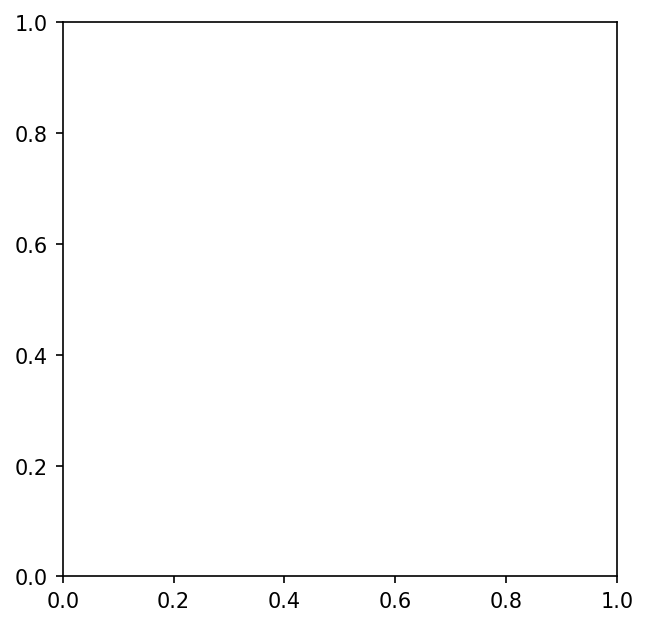

In [77]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(dpi=150)

pressure_plot = fe.plot(p_next,
                        cmap='jet',
                        levels=50)
plt.colorbar(pressure_plot,
             label='Pressure',
             location='bottom')

velocity_plot = fe.plot(u_next,
                        edgecolor='black',
                        linewidth=0.5,
                        minshaft=1,
                        minlength=1.5,
                        title='Velocity/Pressure',)
plt.colorbar(velocity_plot,
             label='Velocity,m/s',
             location='bottom')
fe.plot(mesh, linewidth=0.1)
plt.show()


In [ ]:
# Plot heat
import cmocean

plt.figure(figsize=(14, 14), dpi=150)
heat_plot = fe.plot(
    t_next, 
    cmap=cmocean.cm.thermal,
    levels=50)
#fe.plot(t_next,mode='contour',levels=10,cmap='coolwarm')
plt.colorbar(heat_plot, label='Heat, $\degree C$',location='bottom')
fe.plot(mesh, linewidth=0.1)
fe.plot(u_next,edgecolor='white',cmap=cmocean.cm.speed,alpha=0.1)
plt.show()

In [ ]:
# Plot curl
import cmocean

plt.figure(figsize=(14, 14), dpi=150)
curl_plot = fe.plot(fe.curl(u_next), 
                    cmap=cmocean.cm.balance,
                    levels=10,
                    title='$\operatorname{curl} \mathbf{u}$')
plt.colorbar(curl_plot, label='curl',location='bottom')
fe.plot(mesh, linewidth=0.1)
fe.plot(u_next,cmap=cmocean.cm.speed,alpha = 0.1)
plt.show()